In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms


In [2]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [3]:
batch_size = 5


images = np.load('padded_gray_chair_imgs.npy')
images[:] = (images[:] - np.mean(images[:])) / np.std(images[:])
voxels = np.load('chair_voxels.npy')
print(images[1:1316].shape)
print(images[1316:1416].shape)
train_images = images[1:1316]
val_images = images[1316:1416]
train_voxels = voxels[1:1316]
val_voxels = voxels[1316:1416]

(1315, 128, 128)
(100, 128, 128)


Displaying the object


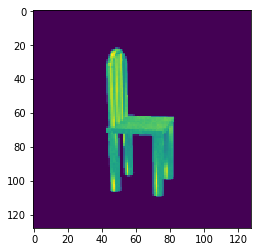

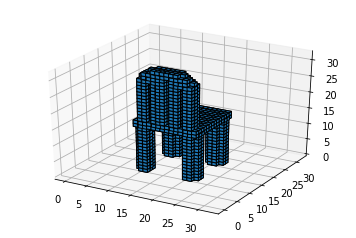

In [4]:
display_id = 56

train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id])
display3DObject(train_voxels[display_id])

In [5]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [18]:
# Conv3d: (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# input size (N,Cin,D,H,W) and output (N,Cout,Dout,Hout,Wout) 
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.cube_len = 32
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
#         print(out.size()) # torch.Size([100, 1, 32, 32, 32])
        out = self.layer1(out)
#         print(out.size())  # torch.Size([100, 32, 16, 16, 16])
        out = self.layer2(out)
#         print(out.size())  # torch.Size([100, 64, 8, 8, 8])
        out = self.layer3(out)
#         print(out.size())  # torch.Size([100, 128, 4, 4, 4])
        out = self.layer4(out)
#         print(out.size())  # torch.Size([100, 256, 2, 2, 2])
        out = self.layer5(out)
#         print(out.size())  # torch.Size([100, 1, 1, 1, 1])
        return out.squeeze()
        

In [19]:
vae = VAE()
vae.cuda()
dis3d = discriminator()
dis3d.cuda()

discriminator(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer5): Sequential(
    (0): Conv3d(256, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): Sigmoid(

In [20]:
# hyperparameters
lr_g = 0.0025
lr_d = 0.001
adam_beta_g = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
D_solver = optim.Adam(dis3d.parameters(), lr=lr_d, betas = adam_beta_d)
G_solver = optim.Adam(vae.parameters(), lr=lr_g, betas = adam_beta_g)

In [21]:
G_Losses = []
D_Losses = []
R_Accs = []
F_Accs = []

In [31]:
#Training the system
num_epochs = 20

loss = nn.BCELoss()

for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    real_accs = []
    fake_accs = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        real_labels = Variable(torch.ones(batch_size).cuda())
        fake_labels = Variable(torch.zeros(batch_size).cuda())
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().unsqueeze(1)
        
        #Discriminator Loss
        generated_object, mu, logvar = vae(var_2D_data)
        generated_object= generated_object.squeeze()
        fake_labels_pred = dis3d(generated_object)
        real_labels_pred = dis3d(var_3D_data)
        loss_fake = loss(fake_labels_pred, fake_labels)
        loss_real = loss(real_labels_pred, real_labels)
        d_loss = loss_fake + loss_real
        d_real_acu = torch.ge(real_labels_pred.squeeze(), 0.5).float()
        d_fake_acu = torch.le(fake_labels_pred.squeeze(), 0.5).float()
        d_real_acu_mean = torch.mean(d_real_acu)
        d_fake_acu_mean = torch.mean(d_fake_acu)
        d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))
        if d_total_acu.data.cpu().numpy() <=0.8:
            dis3d.zero_grad()
            d_loss.backward()
            D_solver.step()
        
        #Generator loss 
        generated_object, mu, logvar = vae(var_2D_data)
        generated_object= generated_object.squeeze()
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        vae_loss = loss(generated_object, var_3D_data) + KLD
        d_fake = dis3d(generated_object)
        g_loss = loss(d_fake, real_labels) + vae_loss

        dis3d.zero_grad()
        vae.zero_grad()
        g_loss.backward()
        G_solver.step()
        
        
        d_losses.append(d_loss.data.cpu().numpy())
        g_losses.append(g_loss.data.cpu().numpy())
        real_accs.append(d_real_acu_mean.data.cpu().numpy())
        fake_accs.append(d_fake_acu_mean.data.cpu().numpy())
        
        
    d_losses_mean = np.mean(np.concatenate(d_losses))
    g_losses_mean =  np.mean(np.concatenate(g_losses))
    real_accs_mean =  np.mean(np.concatenate(real_accs))
    fake_accs_mean =  np.mean(np.concatenate(fake_accs))
    
    print("Epoch: ", epoch, '\n', "D loss: ", d_losses_mean, " G loss: ", g_losses_mean)
    print(" Accuracy: ", (real_accs_mean+ fake_accs_mean)/2 , " Real Acc: ", real_accs_mean, \
          " Fake Acc: ", fake_accs_mean)
    
    G_Losses.append(g_losses_mean)
    D_Losses.append(d_losses_mean)
    R_Accs.append(real_accs_mean)
    F_Accs.append(fake_accs_mean) 

Epoch:  0 
 D loss:  0.3495523  G loss:  3.6408746
 Accuracy:  0.9650189876556396  Real Acc:  0.9726236  Fake Acc:  0.95741445
Epoch:  1 
 D loss:  0.3421627  G loss:  3.1630437
 Accuracy:  0.9608365297317505  Real Acc:  0.9741445  Fake Acc:  0.94752854
Epoch:  2 
 D loss:  0.28467295  G loss:  3.5133047
 Accuracy:  0.9627376794815063  Real Acc:  0.9619772  Fake Acc:  0.9634981
Epoch:  3 
 D loss:  0.31197923  G loss:  3.8595722
 Accuracy:  0.9574143886566162  Real Acc:  0.9558935  Fake Acc:  0.9589353
Epoch:  4 
 D loss:  0.32539228  G loss:  3.2686238
 Accuracy:  0.9604562520980835  Real Acc:  0.955133  Fake Acc:  0.9657795
Epoch:  5 
 D loss:  0.34783298  G loss:  3.2527835
 Accuracy:  0.9566539525985718  Real Acc:  0.956654  Fake Acc:  0.95665395
Epoch:  6 
 D loss:  0.34701705  G loss:  3.2096875
 Accuracy:  0.9638782739639282  Real Acc:  0.96425855  Fake Acc:  0.96349806
Epoch:  7 
 D loss:  0.38835672  G loss:  3.093194
 Accuracy:  0.9501901268959045  Real Acc:  0.94828904  Fake

71
Real Image
torch.Size([1, 1, 128, 128])
Displaying the object


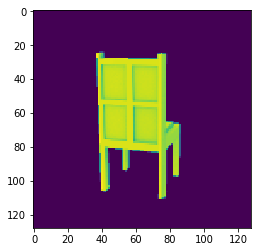

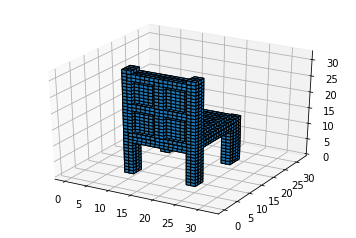

Predicted 3D object
Displaying the object


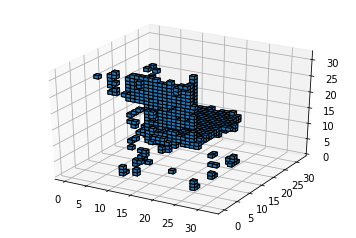

85
Real Image
torch.Size([1, 1, 128, 128])
Displaying the object


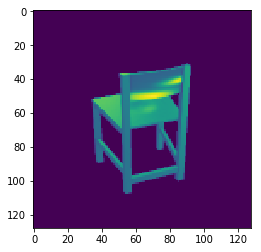

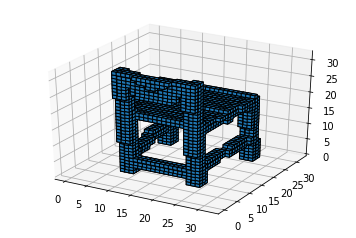

Predicted 3D object
Displaying the object


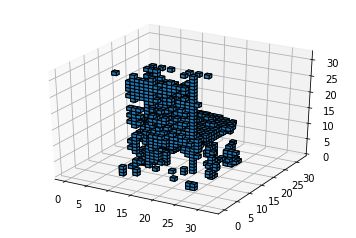

37
Real Image
torch.Size([1, 1, 128, 128])
Displaying the object


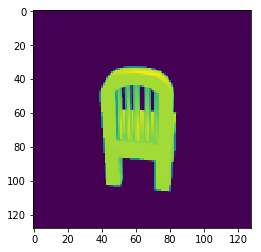

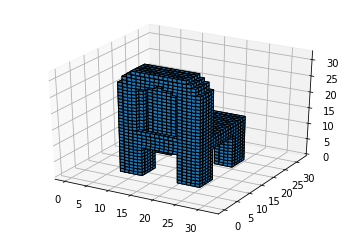

Predicted 3D object
Displaying the object


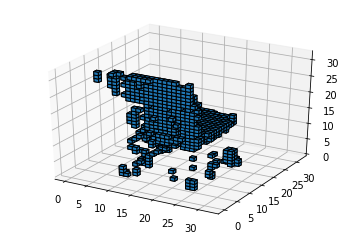

In [32]:
# Generate the 3D Object 
#Testing the general Structure of the VAE
import random
for j in range(0,3):
    i = random.randint(0,99)
    print(i)
    test_image = Variable(torch.FloatTensor(val_images[i])).view(1,1,128,128).cuda()
    print("Real Image")
    plt.imshow(test_image.squeeze().data.cpu().numpy())
    print(test_image.shape)
    test_object,_,_ = vae(test_image)
    test_object = test_object.squeeze().data.cpu().numpy()
    #print("Real 3D voxels")
    #print(val_voxels[i].shape)
    test_voxel = Variable(torch.FloatTensor(val_voxels[i])).data.cpu().numpy()
    display3DObject(test_voxel)
    print("Predicted 3D object")
    display3DObject(test_object >0.5)